# Accumulator payoff pricing using analytical distribution for barrier and gearing strike hit.

We consider that the underlyign equity follows an exponntial Brownian movement, and hence its log returns can be model is a normal distribution: 
$$
 \frac{\Delta S}{S} = \mu \delta T + \sigma( S,t )\sqrt{t}\Delta Z_t 
$$

Under this stochastic process the following probabilies expression hold:
1. Probability of hitting a Down trigger 
$ P_{hit}= P(S \le BL) = \Phi( \frac{\log{BL} - \mu T}{\sigma \sqrt{T}})$
<br/><br/>
2. Probability of hitting a Up trigger 
$ P_{hit}= P(S \ge BL) = 1.0 - \Phi( \frac{\log{BL} - \mu T}{\sigma \sqrt{T}})$
<br/><br/>
In the context of modelling an accumulator payoff with KO and gearing features, both events can be mapped to a barrier trigger affecting the number of equities accumulator over the future time horizon.

In [167]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import  matplotlib.pyplot as plt

 # $ P(S \le BL) $

In [168]:
#P(S <= BL)
def p_hit(T,sigma,S,BL, mu):
    H = BL/S
    x = np.log(H)-mu*T
    sT = sigma*np.sqrt(T)
    return norm.cdf(x/sT)


# $P(\tau \le T)$

In [169]:
def p_hit_before_time(T,sigma,S,K, mu):    
    H = K/S    
    if H>1:
        H = 1.0/H
        mu=-mu
        tmp = S
        S=K
        K=tmp
        
    lnK = np.log(H)
    s2 = sigma**2
    sqrtT = np.sqrt(T)
    sigma05T = sigma*sqrtT
    num = np.exp(2*mu*lnK/s2)*norm.cdf((lnK+mu*T)/sigma05T)
    den = norm.cdf((lnK-mu*T)/sigma05T)
    return (1+num/(den))*p_hit(T,sigma,S,K,mu)


# $p(\tau = T)$

In [170]:
def p_hit_in_t(T,sigma,S,K, mu):
    H = K/S    
    if H>1:
        H = 1.0/H
        mu=-mu
        tmp = S
        S=K
        K=tmp
        
    dt = 1.0/260.0
    a = p_hit_before_time(T+dt,sigma,S,K, mu)
    b = p_hit_before_time(T-dt,sigma,S,K, mu)

    return (a-b)/(2*dt)

# Accumulator Payoff with only Gearing Events
<br>
We study the case of an accumulator with a down gear strike level, $H_{gear}$, which increases the number of accumlated shares per day $\eta$ by a factor g while the spot stays below this trigger level.

$$V(t) = \sum \limits_{i=1}^{N} \eta \times (1+ g \times P(S \le H_{gear}))  $$

# Example Accumulator gearing and without KO
- S=100
- $H_{gear} = 98$
- $ \eta = 1 \times \frac{shares}{day}$
- $ \mu = 0.0 $
- $ T= 1y$
- $\sigma = 45\%$

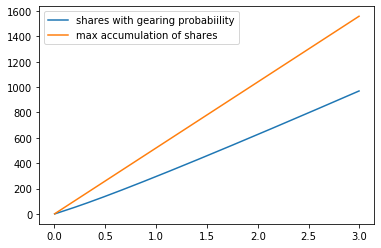

In [171]:
sigma = 0.45/np.sqrt(260.0)
t = np.array(range(1,3*260))/260.0
dt = t[1]-t[0]
S=100.0
K=98.0
shares_per_day = 1
gearing = 1.0
shares_Accumulator_Each_day = [shares_per_day*(1+gearing*p_hit(i,sigma,S,K,0.0))  for i in t]
max_shares_Accumulator_Each_per_day = [shares_per_day*(1+gearing)  for i in t]
max_shares_Accumulator_Each_day = np.cumsum([shares_per_day*(1+gearing)  for i in t])
total_accumulated_shares = np.cumsum(shares_Accumulator_Each_day)
plt.plot(t,total_accumulated_shares,label="shares with gearing probabiility")
plt.plot(t,max_shares_Accumulator_Each_day,label="max accumulation of shares")
plt.legend()

plt.show()

The picture above depicts the difference in between the full share accumulation assumption (over consevative) vs the gearing with hit probability. 

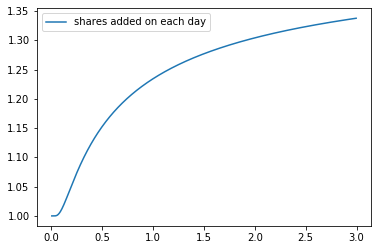

In [172]:
plt.plot(t,shares_Accumulator_Each_day,label="shares added on each day")

plt.legend()
plt.show()

The curve above depicts the number of shares accumulated per day as the time passess. Since no drift is considered on the stock model, $\mu = 0$, to the 1 shares per day standard accumulation, the gearing adds one extra share with probability $P(S\le H_{gear})$. When $t \to \infty$, the probability of hiting the gearing level tends to 50\%, meaning approximates to 1.5 shares per day as time tends to $\infty$.

# Accumulator Payoff with  Gearing and KO Events
<br>
We include the KO probability over time togethe with the feature already presented in the previous simulation. 

In the current simulations the accumulation of shares is conditioned to the fact that the stock has not reached the KO barrier level $BL_{KO}$.


The probability of not being KO at time $\tau$ is simply defined as $P(\tau \ge T) = 1 - P(\tau \le T) $, and the new expression of the accumulated number of shares at the maturity is:
$$V(T) = \sum \limits_{i=1}^{N} \eta \times (1+ g \times P(S \le H_{gear},t_i))\times P(\tau > t_i)  $$

# Example Accumulator gearing and  KO
- S=100
- $H_{gear} = 98$
- $ \eta = 1 \times \frac{shares}{day}$
- $ \mu = 0.0 $
- $ T= 1y$
- $\sigma = 45\%$
- $BL_{KO}=102$

In [173]:
sigma = 0.45/np.sqrt(260.0)
t = np.array(range(1,5*260))/260.0
dt = t[1]-t[0]
S=100.0
K=98.0
shares_per_day = 1
gearing = 1.0
BL_KO=102
mu=0.0





The figure below depicts the probability of knocking out the up barrier over time. As $t \to \infty$ the $P(S\ge BL_{KO}) \to \frac{1}{2})$

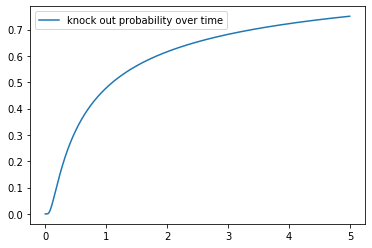

In [174]:
p_ko_t = [(p_hit_before_time(i,sigma,S,BL_KO,mu))  for i in t]
plt.plot(t,p_ko_t, label="knock out probability over time")
plt.legend()

The number of shares accumulated each day with and without KO feature is  depicted in the figure below

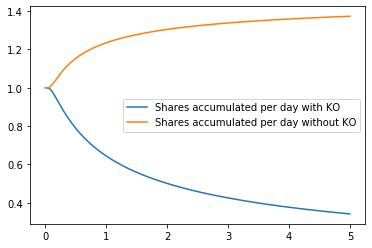

In [175]:
shares_Accumulator_Each_day_with_KO = [shares_per_day*(1+gearing*p_hit(i,sigma,S,K,0.0))*(1.0-p_hit_before_time(i,sigma,S,BL_KO, mu))  for i in t]
shares_Accumulator_Each_day_without_KO = [shares_per_day*(1+gearing*p_hit(i,sigma,S,K,0.0))  for i in t]

plt.plot(t,shares_Accumulator_Each_day_with_KO,label="Shares accumulated per day with KO")
plt.plot(t,shares_Accumulator_Each_day_without_KO,label="Shares accumulated per day without KO")
plt.legend()

The total number of share accumulated with and without KO feature is depicted in the figure below

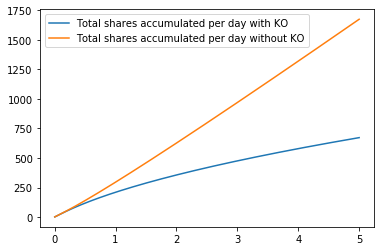

In [176]:
total_shares_Accumulator_Each_day_with_KO = np.cumsum(shares_Accumulator_Each_day_with_KO)
total_shares_Accumulator_Each_day_without_KO = np.cumsum(shares_Accumulator_Each_day_without_KO)

plt.plot(t,total_shares_Accumulator_Each_day_with_KO,label="Total shares accumulated per day with KO")
plt.plot(t,total_shares_Accumulator_Each_day_without_KO,label="Total shares accumulated per day without KO")
plt.legend()

# Accumulation simulation on S&P500

- S=4,509.37
- $H_{gear} = 4283.9$
- $ \eta = 200 \times \frac{shares}{day}$
- $ \mu = 0.0 $
- $ T= 3y$
- $\sigma = 25\%$
- $BL_{KO}=4734.8$
- VaR Factor = 35\%

In [179]:
sigma = 0.25/np.sqrt(260.0)
t = np.array(range(1,3*260))/260.0
dt = t[1]-t[0]
S=4509.37
K=4283.9
shares_per_day = 200
gearing = 1.0
BL_KO=4734.8
mu=0.0
VaR_factor = 0.35
Sup = S*(1+VaR_factor)
Sdown = S*(1-VaR_factor)

/Users/fran/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan na

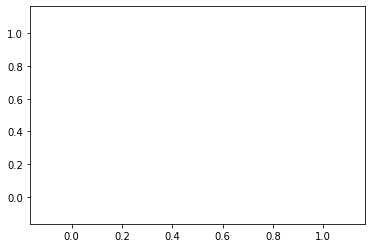

In [182]:
base_line = np.cumsum([shares_per_day*(1+gearing*p_hit(i,sigma,S,K,0.0))*(1.0-p_hit_before_time(i,sigma,S,BL_KO, mu))  for i in t])
Up_Addon_acc_shares = np.cumsum([shares_per_day*(1+gearing*p_hit(i,sigma,Sup,K,0.0))*(1.0-p_hit_before_time(i,sigma,S,BL_KO, mu))  for i in t])
Down_Addon_acc_shares = np.cumsum([shares_per_day*(1+gearing*p_hit(i,sigma,Sdown,K,0.0))*(1.0-p_hit_before_time(i,sigma,S,BL_KO, mu))  for i in t])
print(base_line)
plt.plot(t,base_line, label="baseline")
plt.plot(t,Up_Addon_acc_shares, label="Up_Addon_acc_shares")
plt.plot(t,Down_Addon_acc_shares, label="Down_Addon_acc_shares")